Прежде чем запускать ноутбук надо запустить в таком порядке файлы
1) get_emb.py
2) get_indexes.py

In [1]:
import clip
import torch
import faiss
import matplotlib.pyplot as plt
from utils import evaluate
import numpy as np
from datasets import load_dataset

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [3]:
from xq import xq

In [4]:
len(xq)

86

nlist - Каждый инвертированный список содержит набор векторов, где векторы, близкие друг к другу, 
помещаются в один и тот же список. Большее количество инвертированных списков увеличивает точность, 
но может увеличить использование памяти и время поиска.

nprobe - этот параметр определяет количество инвертированных списков, 
которые будут проверены при поиске ближайших соседей для данного запроса. 
По умолчанию Faiss проверяет только один инвертированный список 
для каждого запроса (поиск по одному списку).

In [5]:
bruteforce_index = faiss.read_index("ind/bruteforce_index.bin")
index_hnsw = faiss.read_index("ind/HNSW.bin")

Сначала посчитаем время для брутфорс индекса

In [26]:
top_k = 200
time_ms_values = []
recall_values = []
nprobe_values = []

In [27]:
index = bruteforce_index
for lnprobe in range(2, 9):
    time_results = []
    recall_results = []
    nprobe = 1 << lnprobe
    for q in xq:
        time_ms, recall = evaluate(bruteforce_index, index, q, top_k, 0, model, device)
        time_results.append(time_ms)
        recall_results.append(recall)
    average_time = sum(time_results) / len(time_results)
    average_recall = sum(recall_results) / len(recall_results)
    time_ms_values.append(average_time)
    recall_values.append(average_recall)
    nprobe_values.append(nprobe)

In [83]:
nlists = [2**j for j in range(2, 9)]

In [29]:
nlists

[4, 8, 16, 32, 64, 128, 256]

In [30]:
top_k = 200
for nlist in nlists:
    index = faiss.read_index(f"ind/IVF_flat_{nlist}.bin")
    for lnprobe in range(2, 9):
        time_results = []
        recall_results = []
        nprobe = 1 << lnprobe
        if (nprobe > nlist):
            break
        index.nprobe = nprobe
        for q in xq:
            time_ms, recall = evaluate(bruteforce_index, index, q, top_k, 0, model, device)
            time_results.append(time_ms)
            recall_results.append(recall)
        average_time = sum(time_results) / len(time_results)
        average_recall = sum(recall_results) / len(recall_results)
        time_ms_values.append(average_time)
        recall_values.append(average_recall)
        nprobe_values.append(nprobe)

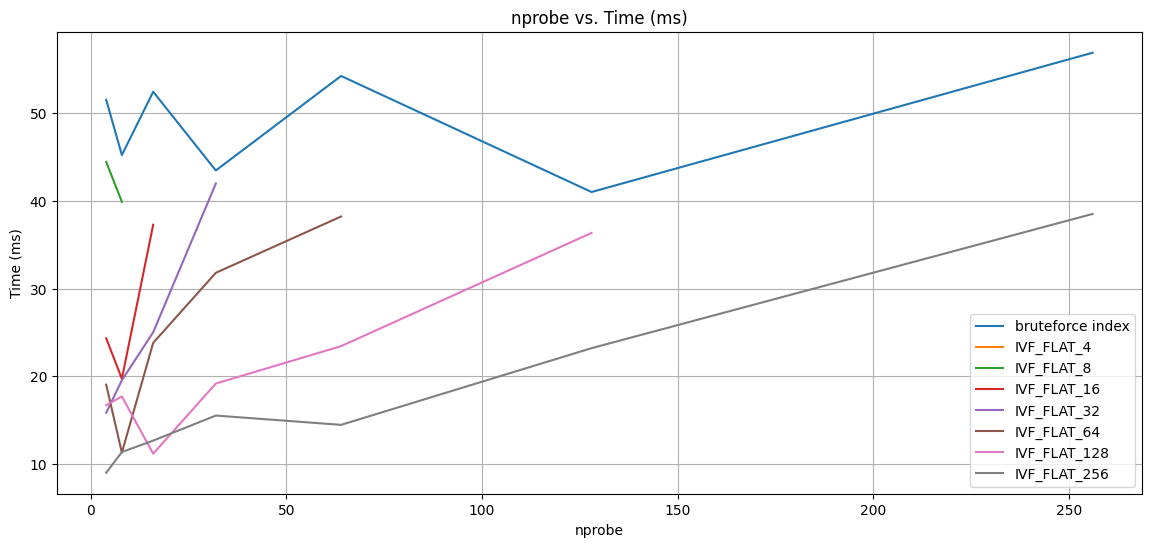

In [94]:
plt.figure(figsize=(14, 6))
plt.plot(nprobe_values[0:7], time_ms_values[0:7], label="bruteforce index")
start = 7
for nlist in nlists:
    end = int(start + np.log2(nlist) - 1)
    plt.plot(nprobe_values[start:end], time_ms_values[start:end], label=f"IVF_FLAT_{nlist}")
    start = end
plt.xlabel('nprobe')
plt.ylabel('Time (ms)')
plt.title('nprobe vs. Time (ms)')
plt.legend()
plt.grid(True)


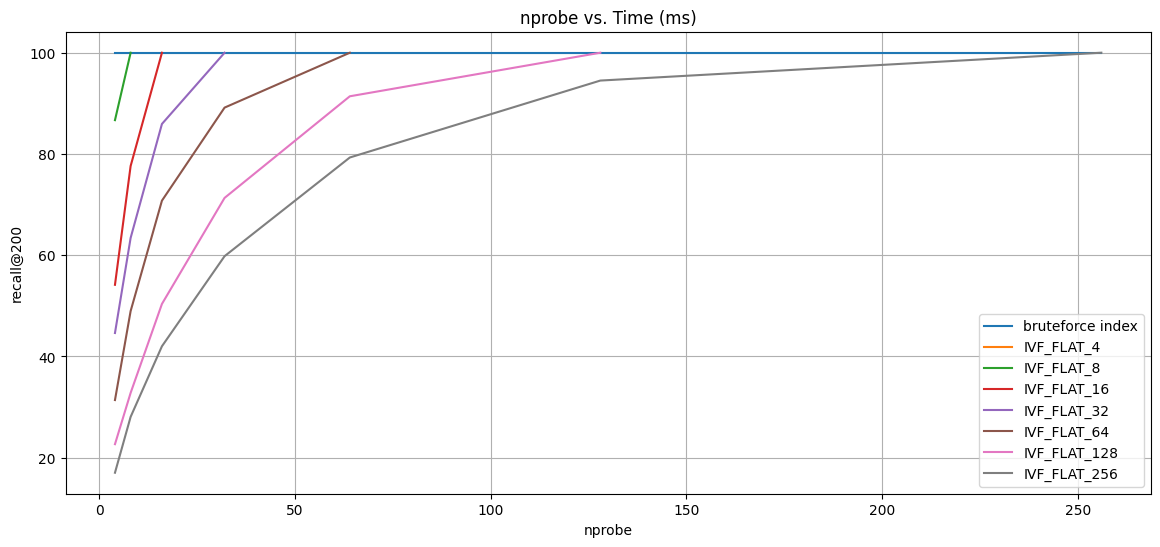

In [98]:
plt.figure(figsize=(14, 6))
plt.plot(nprobe_values[0:7], recall_values[0:7], label="bruteforce index")
start = 7
for nlist in nlists:
    end = int(start + np.log2(nlist) - 1)
    plt.plot(nprobe_values[start:end], recall_values[start:end], label=f"IVF_FLAT_{nlist}")
    start = end
plt.xlabel('nprobe')
plt.ylabel('recall@200')
plt.title('nprobe vs. Time (ms)')
plt.legend()
plt.grid(True)

In [99]:
bruteforce_index = faiss.read_index("ind/bruteforce_index.bin")

hnsw_indexes = []
index = faiss.read_index(f"ind/HNSW.bin")
hnsw_indexes.append(index)
top_k = 200
eFsearch_values_1 = []
time_ms_values_3 = []
recall_values_3 = []

for idx, hnsw_index in enumerate(hnsw_indexes):
    for eFsearch in [50, 100, 150, 200]:
        time_results = []
        recall_results = []
        hnsw_index.hnsw.efSearch = eFsearch
        for q in xq:
            time_ms, recall = evaluate(bruteforce_index, hnsw_index, q, top_k, 0, model, device)
            time_results.append(time_ms)
            recall_results.append(recall)
        average_time = sum(time_results) / len(time_results)
        average_recall = sum(recall_results) / len(recall_results)
        time_ms_values_3.append(average_time)
        recall_values_3.append(average_recall)
        eFsearch_values_1.append(eFsearch)

In [100]:
average_recall

85.73255813953489

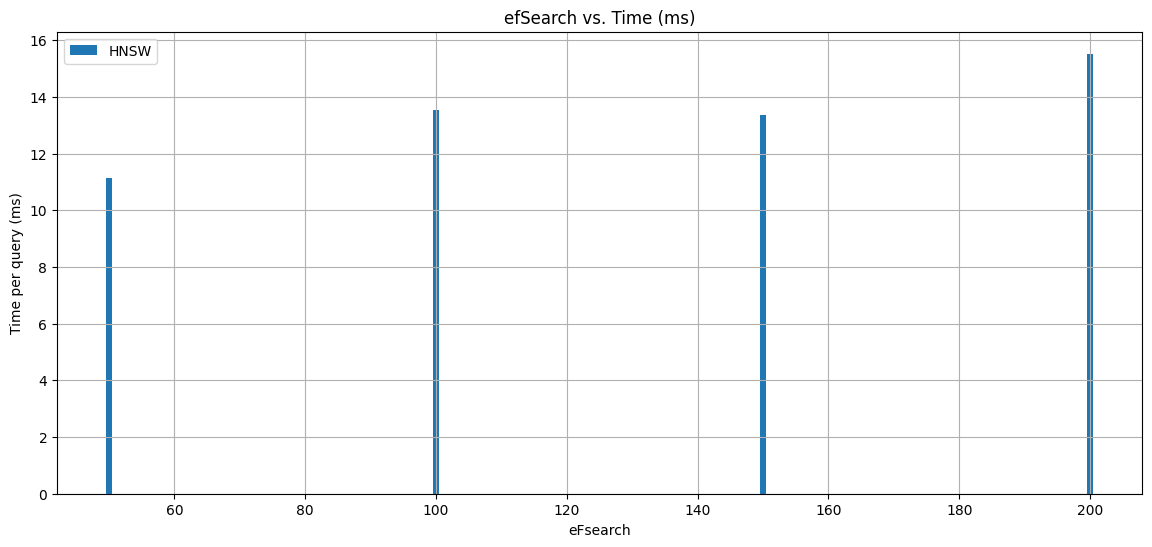

In [101]:
plt.figure(figsize=(14, 6))

# Subplot for the zoomed-in section
plt.bar(eFsearch_values_1, time_ms_values_3, label=f'HNSW')

plt.xlabel('eFsearch')
plt.ylabel('Time per query (ms)')
plt.title('efSearch vs. Time (ms)')
plt.legend()
plt.grid(True)


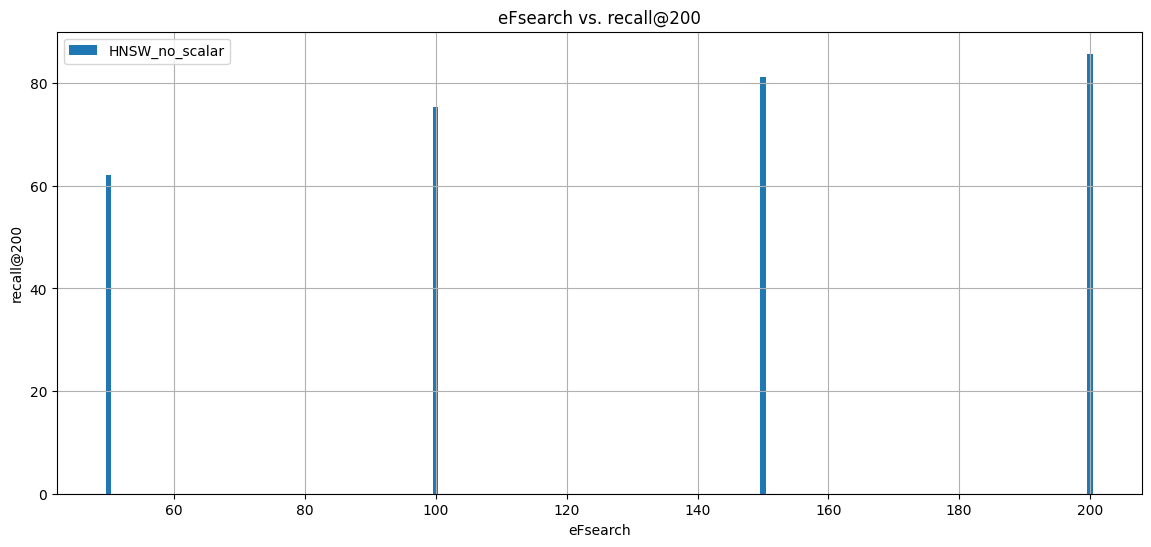

In [102]:
plt.figure(figsize=(14, 6))

# Subplot for the zoomed-in section
plt.bar(eFsearch_values_1, recall_values_3, label=f'HNSW_no_scalar')

plt.xlabel('eFsearch')
plt.ylabel('recall@200')
plt.title('eFsearch vs. recall@200')
plt.legend()
plt.grid(True)

